# Research Question

## Can the outcome(or the odds) of a football match be accurately found using prior match history, and match context.

- Will league affect certain teams?
- Will home team have the advantage?
- Do coaches affect win rate?

# The data

The data in this report contains match history for over 100k games, between teams in many different leagues. The columns we have are the following:
- Winning team(home or away)(binary)
- Home team(categorical)
- Away team(categorical)
- League name(categorical)
- Cup game(Binary)
- Home coach(categorical)
- Away coach(categorical)

Additionally, there are several columns with historical data, up to 10 matches prior, for both the home and away team for each match. Initially, we will not be using this data, but that may change



# Package importing and stuffs

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Data Handling


In [2]:

train=pd.read_csv(r"football-match-probability-prediction/train.csv")

test=pd.read_csv(r"football-match-probability-prediction/test.csv")

train_target_and_scores=pd.read_csv(r"football-match-probability-prediction/train_target_and_scores.csv")




/home/matthias/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
train=train.iloc[:,:10]
train=train.dropna().reset_index()


#mask for seperating training and test data
train_mask=np.full(len(train),False)
train_mask[:int(len(train)*0.5)]=True
np.random.shuffle(train_mask)

##test=test.iloc[:,:10]
#test=test.dropna().reset_index()
#train.head()
#train=train.iloc[train_mask,:]
X_train=train.iloc[:,[0,2,3,4,5,6,7,8,9]]
Y_train=train.iloc[:,2]
print(Y_train)

##X##_test=train.iloc[:,[0,2,3,4,5,6,7,8,9]]
#Y_test=train.iloc[:,2]
#Y_train.head()
L=len(X_train.iloc[:,5].unique()) #number_of_leagues
print(L)
G=len(X_train) #number_of_games
print(G)
Teams=(pd.concat([X_train["away_team_name"],X_train["home_team_name"]]).unique()) # Vector containing all teams in the dataset, by combining home and away teams
T=(len(Teams))
print(T)
#print(X_train["is_cup"].unique())



#Test stuff
#L_test=len(X_test.iloc[:,5].unique()) #number_of_leagues
#print(L)
#G_test=len(X_test) #number_of_games
####print(G)
#Teams_test=(pd.concat([X_test["away_team_name"],X_test["home_team_name"]]).unique()) # Vector containing all teams in the dataset, by combining home and away teams
#T_test=(len(Teams_test))
#print(T)
X_train.head()
#for i in range(len(X_train["away_team_name"])):
#    if X_


#sum(X_train["away_team_name"].isna())


0        away
1        home
2        draw
3        away
4        home
         ... 
84121    draw
84122    away
84123    draw
84124    away
84125    home
Name: target, Length: 84126, dtype: object
656
84126
7805


,index,target,home_team_name,away_team_name,match_date,league_name,league_id,is_cup,home_team_coach_id
0,0,away,Newell's Old Boys,River Plate,2019-12-01 00:45:00,Superliga,636,False,468196.0
1,1,home,Real Estelí,Deportivo Las Sabanas,2019-12-01 01:00:00,Primera Division,752,False,516788.0
2,2,draw,UPNFM,Marathón,2019-12-01 01:00:00,Liga Nacional,734,False,2510608.0
3,3,away,León,Morelia,2019-12-01 01:00:00,Liga MX,743,False,1552508.0
4,4,home,Cobán Imperial,Iztapa,2019-12-01 01:00:00,Liga Nacional,705,False,429958.0


There is not much data handling to do, as most of our data is categorical, and already labelled properly with no missing values. Thus, we can begin smoothly with model building

#TODO Split the training set into a training and test, because for fucked reason the test set provided doesnt have team names.

In [4]:
X_train.head()
X_ = X_train.iloc[:,[2,3]]
print(X_)
X_fac=np.zeros([G,2])
league=pd.factorize(X_train.iloc[:,5])[0]
league_train=league[train_mask]
league_test=league[~train_mask]

#X_fac[:,0],X_fac[:,1],X_fac[:,2] = pd.factorize(X_.iloc[:,0])[0], pd.factorize(X_.iloc[:,1])[0], pd.factorize(X_.iloc[:,2])[0]
#X_fac[:,0],X_fac[:,1] = pd.factorize(X_.iloc[:,0])[0], pd.factorize(X_.iloc[:,1])[0], pd.factorize(X_.iloc[:,2])[0]

#X_fac[:,2] = np.where(Teams==X_train["away_team_name"])[0]


# Compare the teams in the away and home team columns, with the list of all teams so the factorization is consistent.
for i in range(len(X_train["away_team_name"])):
    #print(i)
    #print(X_train["away_team_name"][i])
    #print(np.where(Teams==X_train["away_team_name"][i])[0])
    
    X_fac[:,1][i]=np.where(Teams==X_train["away_team_name"][i])[0]
for i in range(len(X_train["home_team_name"])):
    #print(i)
    #print(X_train["home_team_name"][i])
    #print(np.where(Teams==X_train["home_team_name"][i])[0])
    
    X_fac[:,0][i]=np.where(Teams==X_train["home_team_name"][i])[0]

           home_team_name         away_team_name
0       Newell's Old Boys            River Plate
1             Real Estelí  Deportivo Las Sabanas
2                   UPNFM               Marathón
3                    León                Morelia
4          Cobán Imperial                 Iztapa
...                   ...                    ...
84121  Zamora Fútbol Club    Hermanos Colmenares
84122          Royal Pari      Oriente Petrolero
84123        São Bernardo             Água Santa
84124             Everton              La Serena
84125               Colón     Arsenal de Sarandi

[84126 rows x 2 columns]


# Model 1


In [5]:
def hierarchical_model(X,league, L , G, obs=None):

    input_dim = X.shape[0]
    
    mu_l=pyro.sample("mu_l", dist.Normal(torch.zeros(input_dim),10*torch.ones(input_dim)).to_event())
    sigma_l=pyro.sample("sigma_l", dist.HalfNormal(10*torch.ones(input_dim)).to_event())
    
       
    with pyro.plate("League",L):
        
        Beta_l=pyro.sample("Beta_l",dist.Normal(mu_l,sigma_l).to_event(1)) # Getting individual beta parameters for each league


    with pyro.plate("Games",G):

        param=Beta_l[league]*X.T
        confidence=torch.nn.functional.softmax(param,dim=1)
        outcome = pyro.sample("outcome",dist.Categorical(confidence),obs=obs)




# Alpha will be a function of beta_l*inputs, and beta will be 1-that. 
# so, beta*l*inputs needs to be between 0 and 1.

        


    return outcome

# Model 2

In [6]:
def hierarchical_model(X,league, L , G, obs=None):
   # print("1")
    input_dim = X.shape[1]
    
    mu_l=pyro.sample("mu_l", dist.Normal(torch.zeros(input_dim),10*torch.ones(input_dim)).to_event())
    sigma_l=pyro.sample("sigma_l", dist.HalfNormal(10*torch.ones(input_dim)).to_event())
    
       
    with pyro.plate("League",L):
      #  print("2")
        Beta_l=pyro.sample("Beta_l",dist.Normal(mu_l,sigma_l).to_event(1)) # Getting individual beta parameters for each league


    with pyro.plate("Games",G):
      #  print("3")
        param=Beta_l[league]*X
        #print(param,param.shape)
        
        param=torch.sigmoid(param)+1

        #print(param,param.shape)
        confidence=pyro.sample("confidence",dist.Dirichlet(param))
        #print(confidence)
        outcome = pyro.sample("outcome",dist.Categorical(confidence),obs=obs)




# Alpha will be a function of beta_l*inputs, and beta will be 1-that. 
# so, beta*l*inputs needs to be between 0 and 1.

        


    return outcome

# Model 3

In [7]:
def hierarchical_model(X,league, L , G,T, obs=None):
    #print("1")
    input_dim = X.shape[1]
    
    mu_l=pyro.sample("mu_l", dist.Normal(torch.zeros(input_dim),10*torch.ones(input_dim)).to_event())
    sigma_l=pyro.sample("sigma_l", dist.HalfNormal(10*torch.ones(input_dim)).to_event())
    sigma_t=pyro.sample("sigma_t", dist.HalfNormal(1).to_event())
    mu_t=pyro.sample("mu_t", dist.Normal(0,1).to_event())
    #print("2") 
    with pyro.plate("League",L):
        #print("3",T)
        Beta_l=pyro.sample("Beta_l",dist.Normal(mu_l,sigma_l).to_event(1)) # Getting individual beta parameters for each league

    with pyro.plate("Team",T):
       # print("4")
        Beta_t=pyro.sample("Beta_t",dist.Normal(mu_t,sigma_t).to_event()) # Getting individual beta parameters for each team
    #print(Beta_t.shape)
    with pyro.plate("Games",G):
 
        param1=Beta_l[league].T[0]*Beta_t[X.T[0].detach().numpy()]#
        
        param2=Beta_l[league].T[1]*Beta_t[X.T[1].detach().numpy()]
        param1=torch.sigmoid(param1)+1
        param2=torch.sigmoid(param2)+1
        #print(param2.shape[0])
        #print(torch.vstack([param1,torch.ones((param2.shape[0])),param2]))
        confidence=pyro.sample("confidence",dist.Dirichlet(torch.vstack([param1,torch.ones((param2.shape[0])),param2]).T))
        outcome = pyro.sample("outcome",dist.Categorical(confidence),obs=obs)




# Alpha will be a function of beta_l*inputs, and beta will be 1-that. 
# so, beta*l*inputs needs to be between 0 and 1.

        


    return outcome

In [54]:


%%time




#print(Y_train)
Y_fac=pd.factorize(Y_train)[0]
#league=X_fac[:,3]
#print(Y_fac)
#print(X_fac)
# Define guide function
guide = AutoDiagonalNormal(hierarchical_model)
        #AutoDiagonalNormal

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 500

# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(hierarchical_model, guide, optimizer, loss=elbo)

# Do gradient steps
#G=10000
X_fac_train=X_fac[train_mask,:]
Y_fac_train=Y_fac[train_mask]
X_fac_test=X_fac[~train_mask,:]
Y_fac_test=Y_fac[~train_mask]
G=len(X_fac_train[:,0])
print(G)
X_fac_train=torch.tensor(X_fac_train)
#X_fac=X_fac[:G,:]
#print(Y_fac)
#Y_fac=Y_fac[:G]
#league=league[:G]
#print(X_fac)
Y_fac_train=torch.tensor(Y_fac_train)




for step in range(n_steps):
    elbo = svi.step(X_fac_train,league_train, L,G,T, Y_fac_train) 
    if step % 100 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))




42063
[0] ELBO: 235550.1
[100] ELBO: 179469.4
[200] ELBO: 137396.6
[300] ELBO: 105495.3
[400] ELBO: 82247.6
CPU times: user 5min 14s, sys: 673 ms, total: 5min 15s
Wall time: 41.8 s


# Extracting posterior samples
#### For both training and test data

In [56]:
from pyro.infer import Predictive
''

X_fac_test=torch.tensor(X_fac_test)
Y_fac_test=torch.tensor(Y_fac_test)
print(X_fac_test.shape,league_test.shape, L,T, Y_fac_test.shape)
print(len(X_fac_test[:,0]))
predictive = Predictive(hierarchical_model, guide=guide, num_samples=2000,
                        return_sites=("Beta_l","Beta_t","confidence"))
samples = predictive(X_fac_train,league_train, L,len(X_fac_train[:,0]),T, Y_fac_train)

predictive_test = Predictive(hierarchical_model, guide=guide, num_samples=2000,
                        return_sites=("Beta_l","Beta_t","confidence"))
samples_test = predictive_test(X_fac_test,league_test, L,len(X_fac_test[:,0]),T, Y_fac_test)





#mu_l_samples = samples["mu_l"].detach().numpy()
#sigma_l_samples = samples["sigma_l"].detach().numpy()
#beta_l_samples = samples["Beta_l"].detach().numpy()
#Beta_t_samples = samples["Beta_t"].detach().numpy()
#outcome_samples = samples["outcome"].detach().numpy()
confidence_samples = samples["confidence"].detach().numpy()
confidence_samples_test = samples_test["confidence"].detach().numpy()
y_hat=np.argmax(confidence_samples.mean(axis=0),axis=1)
y_hat_test=np.argmax(confidence_samples_test.mean(axis=0),axis=1)
#print(y_hat.shape)
#print(Y_fac_test.shape)
Y_fac=Y_fac_train.detach().numpy()
Y_fac_testt=Y_fac_test.detach().numpy()
print("Training Accuracy: ",np.sum(Y_fac==y_hat)/len(y_hat))
print("Test Accuracy:        ",np.sum(Y_fac_testt==y_hat_test)/len(y_hat_test)) #FOR some reason, y_hat_test and y_hat are the same.
print(np.sum(y_hat==y_hat_test)/len(y_hat))


/tmp/ipykernel_9488/2623818843.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_fac_test=torch.tensor(X_fac_test)
/tmp/ipykernel_9488/2623818843.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_fac_test=torch.tensor(Y_fac_test)


torch.Size([42063, 2]) (42063,) 656 7805 torch.Size([42063])
42063
Training Accuracy:  0.8203171433326201
Test Accuracy:         0.3182369303188075
0.9227111713382308


In [46]:
print(X_fac_test)
print(X_fac_train)

[[1.812e+03 0.000e+00]
 [1.337e+03 5.000e+00]
 [2.856e+03 7.000e+00]
 ...
 [6.130e+03 6.101e+03]
 [1.142e+03 1.148e+03]
 [4.470e+03 4.338e+03]]
tensor([[2.2570e+03, 1.0000e+00],
        [2.2510e+03, 2.0000e+00],
        [4.2360e+03, 3.0000e+00],
        ...,
        [4.9410e+03, 7.3600e+03],
        [5.7400e+02, 4.6060e+03],
        [6.8200e+02, 1.8040e+03]], dtype=torch.float64)


In [ ]:
for c in range(3):
    sns.distplot(mu_l_samples[:,0,c])
plt.legend(["mu_l[%d]" % c for c in range(3)])
plt.show()

NameError: name 'mu_l_samples' is not defined

/home/matthias/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matthias/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matthias/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

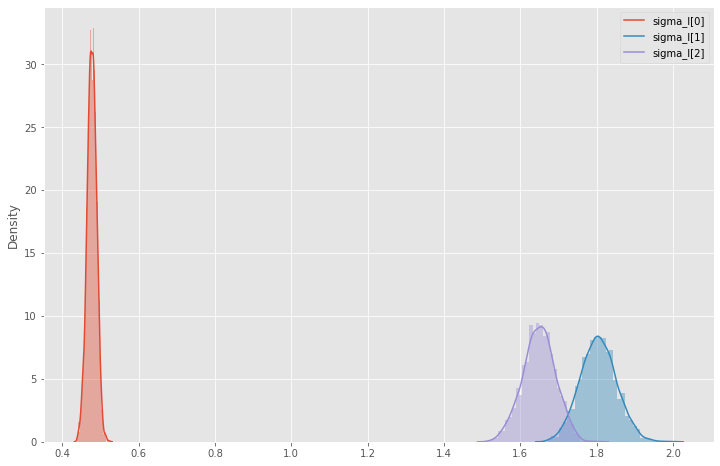

In [ ]:
for c in range(3):
    sns.distplot(sigma_l_samples[:,0,c])
plt.legend(["sigma_l[%d]" % c for c in range(3)])
plt.show()

(1000, 656, 3)


/home/matthias/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matthias/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/matthias/.local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

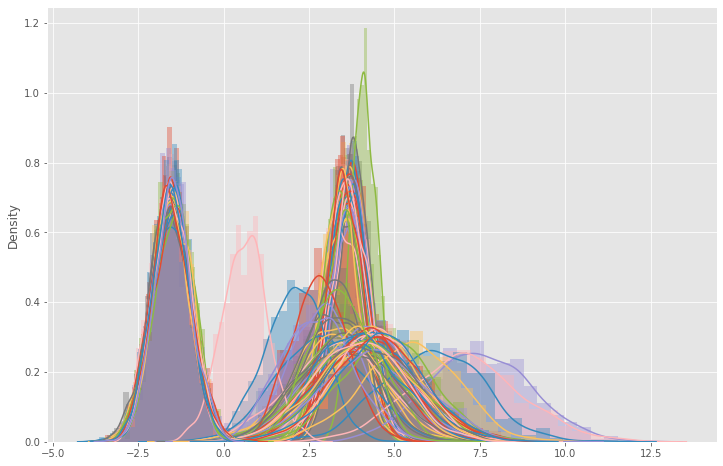

In [ ]:
print(beta_l_samples.shape)
for d in range(3):
    for c in range(50):
        sns.distplot(beta_l_samples[:,c,d])
#plt.legend(["beta_l[%d]" %
#  c for c in range(3)])
plt.show()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
x1=beta_l_samples.mean(axis=0)[league]
#print(x1.shape)
#print(())
x2=np.vstack([Beta_t_samples.mean(axis=0)[X_fac.T[0].detach().numpy().astype(int)],Beta_t_samples.mean(axis=0)[X_fac.T[1].detach().numpy().astype(int)]]).T
#print(x2.shape)
y_hat=x1[:,[0,1]]*x2
print(y_hat)
y_hat=np.argmax(y_hat,axis=1)
Y_fac=Y_fac.detach().numpy()
print(np.sum(Y_fac==y_hat)/len(y_hat))


[[2.6436465 0.8301626]
 [2.675058  2.2524104]
 [2.155438  1.5746855]
 ...
 [2.0185635 0.6074802]
 [2.8525038 2.2524514]
 [2.7649086 0.8836078]]
0.31556237072961985


[0 1 2 ... 2 0 1]
0.926348572379526
